In [1]:
################################
## Getting started & Data Set ##
################################

import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#one_hot=TRUE: Conduct one-hot-encoding, i.e. the digit "1" [integer encoding] 
#              will be represented as (0,1,0,0,0,0,0,0,0,0).
#              28x28 pixels are flattened into a 784 vector
#              Grayscale of each pixel between 0 and 255 (black 255)

print(mnist.train.num_examples) # #55 000 train data
print(mnist.validation.num_examples) # #5000 validation data
print(mnist.test.num_examples) # #10 000 test data

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
55000
5000
10000


In [2]:
##################################
## How does the data look like? ##
##################################

import numpy as np
import matplotlib.pyplot as plt

i=1

dig = np.argmax(mnist.train.labels[i,:])
#argmax due to one-hot encoding.
#compare to using:
#dig = mnist.train.labels[i,:]

img = np.reshape(mnist.train.images[i,:], [28,28])
plt.imshow(img, cmap='Greys')
plt.show()
print(dig)

<Figure size 640x480 with 1 Axes>

3


In [3]:
####################
## Architecture I ##
####################

## Five Layer NN
n_input = 784  # input layer (28x28 pixels)
#n_1 = 512  # 1st hidden layer -> are now convolutional layers
n_1 = 4
#n_2 = 256  # 2nd hidden layer -> are now convolutional layers
n_2 = 8
#n_3 = 128  # 3rd hidden layer -> are now convolutional layers
n_3 = 12
n_4 = 200   # 4th hidden layer
n_output = 10  # output layer (0-9 digits)

#Define 2 tensors as placeholders (tensors that we'll feed with values later)

x     = tf.placeholder("float", [None, n_input])   #None x 784
ystar = tf.placeholder("float", [None, n_output])  #None x 10
p     = tf.placeholder(tf.float32)

#PREVIOUS: Ystar = Y

In [4]:
#####################
## Hyperparameters ##
#####################

learning_rate = 1e-4
n_iterations = 10000
batch_size = 128
#batch_size = 4112

In [5]:
#######################################
## Architecture II & Getting Started ##
#######################################

# Initial values for Weights

weights = {
    'w1': tf.Variable(tf.truncated_normal([5, 5, 1, n_1], stddev=0.1)),
          #5x5 filter, 1 input depth,   n_1 output depth
    'w2': tf.Variable(tf.truncated_normal([5, 5, n_1, n_2], stddev=0.1)),
          #5x5 filter, n_1 input depth, n_2 output depth
    'w3': tf.Variable(tf.truncated_normal([4, 4, n_2, n_3], stddev=0.1)),
          #4x4 filter, n_2 input depth, n_3 output depth
    'w4': tf.Variable(tf.truncated_normal([7*7*n_3, n_4], stddev=0.1)),
          #the output of the last conv. layer is 7 x 7 x n_3 (length x height x depth)
          #this cube will be flattened into an 7*7*n_3 tensor
    'w5': tf.Variable(tf.truncated_normal([n_4, n_output], stddev=0.1)),
}


biases = {
    'b1': tf.Variable(tf.constant(0.1, shape = [n_1])),
    'b2': tf.Variable(tf.constant(0.1, shape = [n_2])),
    'b3': tf.Variable(tf.constant(0.1, shape = [n_3])),
    'b4': tf.Variable(tf.constant(0.1, shape = [n_4])),
    'b5': tf.Variable(tf.constant(0.00001, shape = [n_output])),
}




h_1 = tf.maximum(tf.nn.conv2d(tf.reshape(x, [-1,28,28,1]), weights['w1'], strides=[1, 1, 1, 1], padding='SAME') + biases['b1'], 0)
# we have to reshape the input x to its original 28x28x1 structure
# output is 28x28, since input is 28x28 and stride = 1
# use ReLU activation function
h_2 = tf.maximum(tf.nn.conv2d(h_1, weights['w2'], strides=[1, 2, 2, 1], padding='SAME') + biases['b2'], 0)
# output is 14x14, since input is 28x28 and stride = 2 (which halves the input size)
# use ReLU activation function
h_3 = tf.maximum(tf.nn.conv2d(h_2, weights['w3'], strides=[1, 2, 2, 1], padding='SAME') + biases['b3'], 0)
# output is 7x7, since input is 14x14 and stride = 2 (which halves the input size)
# use ReLU activation function

# Now flatten the output into a 1 x 7*7*n_3 tensor:
h_3 = tf.reshape(h_3, shape=[-1, 7 * 7 * n_3])   
h_4 = tf.nn.dropout(tf.maximum(tf.add(tf.matmul(h_3, weights['w4']), biases['b4']), 0), p)   #ReLU
y   = tf.math.softmax(tf.matmul(h_4, weights['w5']) + biases['b5'])                          #Softmax
#PREVIOUS: y = output_layer


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
####################################
## Loss Function and Optimization ##
####################################
cross_entropy = -tf.reduce_mean(ystar * tf.log(y)) + 0.00001    #don't use the python-function anymore
                                                                #code it mathematically
#cross_entropy = tf.reduce_mean(   
#    tf.nn.softmax_cross_entropy_with_logits(  #use cross_entropy norm
#        labels=ystar, logits = y
#        ))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
#                      #use the Adam Gradient Descent Optimizer

In [7]:
#####################
## Define Accuracy ##
#####################

correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(ystar, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [8]:
################
## Run the NN ##
################
dropout = 0.5
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

t_loss = [None] * int(n_iterations/100)
b_loss = [None] * int(n_iterations/100)

t_acc = [None] * int(n_iterations/100)
b_acc = [None] * int(n_iterations/100)

for i in range(n_iterations):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    
    #batch_x = tf.reshape(batch_x, [-1,28,28,1])
    sess.run(train_step, feed_dict={
        x: batch_x, ystar: batch_y, p: 0.75}
            )

    # print loss and accuracy (per minibatch)
    if i % 100 == 0:
        minibatch_loss, minibatch_accuracy = sess.run(
            [cross_entropy, accuracy],
            feed_dict={x: batch_x, ystar: batch_y, p: 0.75}
            )
        
        test_accuracy = sess.run(accuracy, feed_dict={
            x: mnist.test.images, ystar: mnist.test.labels, p: 1
        })
        test_loss     = sess.run(cross_entropy, feed_dict={
            x: mnist.test.images, ystar: mnist.test.labels, p: 1
        }) 
        
        
        j=int(i/100)
        t_loss[j] = test_loss
        b_loss[j] = minibatch_loss
        
        t_acc[j]  = test_accuracy
        b_acc[j]  = minibatch_accuracy
        
        print(
            "Iteration",
            str(i),
            "\t Minibatch-Loss =",
            str(minibatch_loss),
            "\t Minibatch-Accuracy =",
            str(minibatch_accuracy))
        print(
            "Iteration",
            str(i),
            "\t Test-loss      =",
            str(test_loss),
            "\t Test-Accuracy      =",
            str(test_accuracy)
            )
        print("------------------------------------------------------------------------------")

Iteration 0 	 Minibatch-Loss = 0.23188666 	 Minibatch-Accuracy = 0.1328125
Iteration 0 	 Test-loss      = 0.23030078 	 Test-Accuracy      = 0.1393
------------------------------------------------------------------------------
Iteration 100 	 Minibatch-Loss = 0.20847856 	 Minibatch-Accuracy = 0.3671875
Iteration 100 	 Test-loss      = 0.20825718 	 Test-Accuracy      = 0.5149
------------------------------------------------------------------------------
Iteration 200 	 Minibatch-Loss = 0.1212745 	 Minibatch-Accuracy = 0.6484375
Iteration 200 	 Test-loss      = 0.11523244 	 Test-Accuracy      = 0.7922
------------------------------------------------------------------------------
Iteration 300 	 Minibatch-Loss = 0.05919627 	 Minibatch-Accuracy = 0.828125
Iteration 300 	 Test-loss      = 0.052880038 	 Test-Accuracy      = 0.8661
------------------------------------------------------------------------------
Iteration 400 	 Minibatch-Loss = 0.04886139 	 Minibatch-Accuracy = 0.859375
Iteration

Iteration 3600 	 Minibatch-Loss = 0.013492464 	 Minibatch-Accuracy = 0.953125
Iteration 3600 	 Test-loss      = 0.009418728 	 Test-Accuracy      = 0.9705
------------------------------------------------------------------------------
Iteration 3700 	 Minibatch-Loss = 0.007199378 	 Minibatch-Accuracy = 0.984375
Iteration 3700 	 Test-loss      = 0.009105887 	 Test-Accuracy      = 0.9709
------------------------------------------------------------------------------
Iteration 3800 	 Minibatch-Loss = 0.016088923 	 Minibatch-Accuracy = 0.9609375
Iteration 3800 	 Test-loss      = 0.009009834 	 Test-Accuracy      = 0.9707
------------------------------------------------------------------------------
Iteration 3900 	 Minibatch-Loss = 0.009432679 	 Minibatch-Accuracy = 0.953125
Iteration 3900 	 Test-loss      = 0.008850079 	 Test-Accuracy      = 0.971
------------------------------------------------------------------------------
Iteration 4000 	 Minibatch-Loss = 0.015638452 	 Minibatch-Accuracy =

Iteration 7200 	 Minibatch-Loss = 0.0051924125 	 Minibatch-Accuracy = 0.984375
Iteration 7200 	 Test-loss      = 0.006252232 	 Test-Accuracy      = 0.9798
------------------------------------------------------------------------------
Iteration 7300 	 Minibatch-Loss = 0.006969784 	 Minibatch-Accuracy = 0.9765625
Iteration 7300 	 Test-loss      = 0.0060996907 	 Test-Accuracy      = 0.9806
------------------------------------------------------------------------------
Iteration 7400 	 Minibatch-Loss = 0.009188894 	 Minibatch-Accuracy = 0.9609375
Iteration 7400 	 Test-loss      = 0.005988693 	 Test-Accuracy      = 0.9815
------------------------------------------------------------------------------
Iteration 7500 	 Minibatch-Loss = 0.0098183965 	 Minibatch-Accuracy = 0.96875
Iteration 7500 	 Test-loss      = 0.0061796214 	 Test-Accuracy      = 0.9799
------------------------------------------------------------------------------
Iteration 7600 	 Minibatch-Loss = 0.0095237 	 Minibatch-Accurac

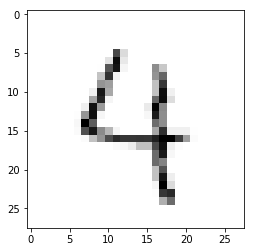

Prediction: 4


In [15]:
#######################################
## Checking the performance manually ##
#######################################

test_digit = 24

img = np.reshape(mnist.test.images[test_digit,:], [28,28])
plt.imshow(img, cmap='Greys')
plt.show()

#dig = np.argmax(mnist.test.labels[test_digit,:])
#print(dig)

prediction = sess.run(tf.argmax(y, 1), feed_dict={x: mnist.test.images})
print ("Prediction:", np.squeeze(prediction)[test_digit])

Text(0.5, 1.0, 'Loss for Minibatch (red) and Test-Data (blue)')

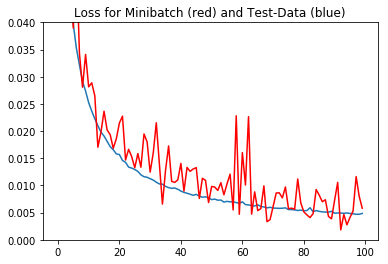

In [48]:
pr = np.arange(int(n_iterations/100))
plt.ylim(0,0.04)
plt.plot(pr,t_loss, pr, b_loss, 'r')
plt.title('Loss for Minibatch (red) and Test-Data (blue)')

Text(0.5, 1.0, 'Accuracy for Minibatch (red) and Test-Data (blue)')

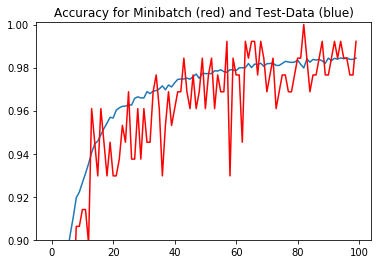

In [49]:
pr = np.arange(int(n_iterations/100))
plt.ylim(0.9,1.001)
plt.plot(pr,t_acc, pr, b_acc, 'r')
plt.title('Accuracy for Minibatch (red) and Test-Data (blue)' )